<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%202/Case_Study_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score



In [130]:
df = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%202/diabetic_data.csv")
ID_map = pd.read_csv("https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%202/IDs_mapping.csv")

admission_source = ID_map.drop(['admission_description', 'discharge_description'], axis=1)
admission = ID_map.drop(['admission_source_description', 'discharge_description'], axis=1)
discharge = ID_map.drop(['admission_description', 'admission_source_description'], axis=1)

df=pd.merge(df, admission, 
            left_on='admission_type_id', 
            right_on='id', 
            how='left' 
)


df=pd.merge(df, discharge, 
            left_on='discharge_disposition_id', 
            right_on='id', 
            how='left' 
)
df=pd.merge(df, admission_source, 
            left_on='admission_source_id', 
            right_on='id', 
            how='left' 
)


Upon first inspection there do not appear to be any NAs

In [131]:
#sorting the dataframe by patient_nbr and encounter_id, in order to filter out the repeat values 
df=df.sort_values(by=['patient_nbr', 'encounter_id'])

#filtering out repeat values by patient_nbr
df=df.groupby('patient_nbr').first()
len(df)

71518

In [132]:
df = df[df.columns.drop(list(df.filter(regex='_x')))]
df = df[df.columns.drop(list(df.filter(regex='_y')))]
df = df[df.columns.drop(list(df.filter(regex='id')))]

#removing number emergency, as it is tied to the readmission column we are predicting on
#df = df[df.columns.drop(list(df.filter(regex='number_emergency')))]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 135 to 189502619
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   race                          71518 non-null  object
 1   gender                        71518 non-null  object
 2   age                           71518 non-null  object
 3   weight                        71518 non-null  object
 4   time_in_hospital              71518 non-null  int64 
 5   payer_code                    71518 non-null  object
 6   medical_specialty             71518 non-null  object
 7   num_lab_procedures            71518 non-null  int64 
 8   num_procedures                71518 non-null  int64 
 9   num_medications               71518 non-null  int64 
 10  number_outpatient             71518 non-null  int64 
 11  number_emergency              71518 non-null  int64 
 12  number_inpatient              71518 non-null  int64 
 13  diag_1    

In [133]:
df.head()

,race,gender,age,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_description,discharge_description,admission_source_description
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,Caucasian,Female,[50-60),?,8,?,Cardiology,77,6,33,...,No,Steady,No,No,Ch,Yes,<30,Urgent,Discharged to home,Physician Referral
378,Caucasian,Female,[50-60),?,2,?,Surgery-Neuro,49,1,11,...,No,No,No,No,No,No,NO,Elective,Discharged to home,Physician Referral
729,Caucasian,Female,[80-90),?,4,MC,InternalMedicine,68,2,23,...,No,No,No,No,No,Yes,NO,Emergency,Discharged/transferred to SNF,Emergency Room
774,Caucasian,Female,[80-90),?,3,?,InternalMedicine,46,0,20,...,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
927,AfricanAmerican,Female,[30-40),?,5,?,InternalMedicine,49,0,5,...,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room


The weight column has a question mark (?), corresponding to missing weights, these are effectively NAs.
Also, target is not binary in this case, however, our aim is to predict rehospitalization within 30 days, a binary (yes or no) response.


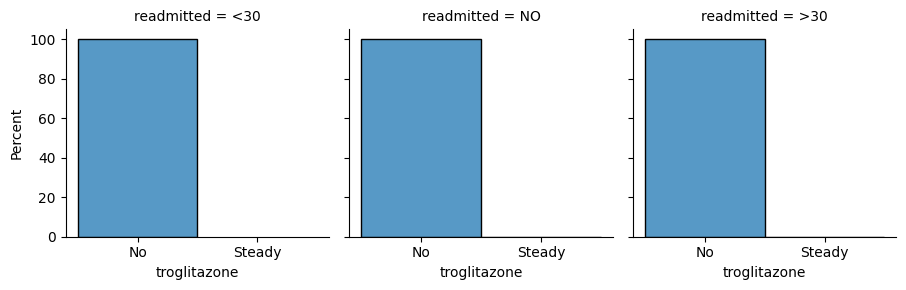

In [134]:
aPlot2 = sns.FacetGrid(df,
                       col = 'readmitted',
                       col_wrap = 4)

aPlot2.map(sns.histplot, 
           'troglitazone',
           stat = 'percent')
plt.show()

#removing troglitazone due to lack of information available in column

df=df.drop(['troglitazone'], axis=1)

In [135]:
# Get count duplicates single column using dataframe.pivot_table()
df2 = df.pivot_table(index = ['patient_nbr'], aggfunc ='size')
print(df2)

patient_nbr
135          1
378          1
729          1
774          1
927          1
            ..
189351095    1
189365864    1
189445127    1
189481478    1
189502619    1
Length: 71518, dtype: int64


When we look at the data by patient number, we can see that the number of rows drops from 101,766 down to 71,518. We will be dropping the repeated values.

In [136]:
for i in df.columns:
  count = df.loc[df[i]=='?',i].count()
  if count > 0:
    print('{}:'.format(i),
          '{}%'.format(np.round(np.divide(count,len(df))*100,2)))

race: 2.72%
weight: 96.01%
payer_code: 43.41%
medical_specialty: 48.21%
diag_1: 0.02%
diag_2: 0.41%
diag_3: 1.71%


Three variables have a large percentage of missing values, Weight, Payer_code and Medical_speciatly with about 97%, 40% and 49% of missing values accordingly. Race and diags 1-3 all have a smaller number of missing values.

In [137]:
#dropping columns with high # of missing values
df=df.drop(['weight'], axis=1)
df=df.drop(['medical_specialty'], axis=1)
df=df.drop(['payer_code'], axis=1)

In [138]:
# Replacing the ? with nan
df=df.replace("?", np.nan)

In [139]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,71518.00000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000,71518.000000
mean,4.28913,43.075478,1.430577,15.705025,0.280069,0.103540,0.177829,7.245700
std,2.94921,19.952338,1.759864,8.311163,1.068957,0.509187,0.603790,1.994674
min,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2.00000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,3.00000,44.000000,1.000000,14.000000,0.000000,0.000000,0.000000,8.000000
75%,6.00000,57.000000,2.000000,20.000000,0.000000,0.000000,0.000000,9.000000
max,14.00000,132.000000,6.000000,81.000000,42.000000,42.000000,12.000000,16.000000


IndexError: ignored

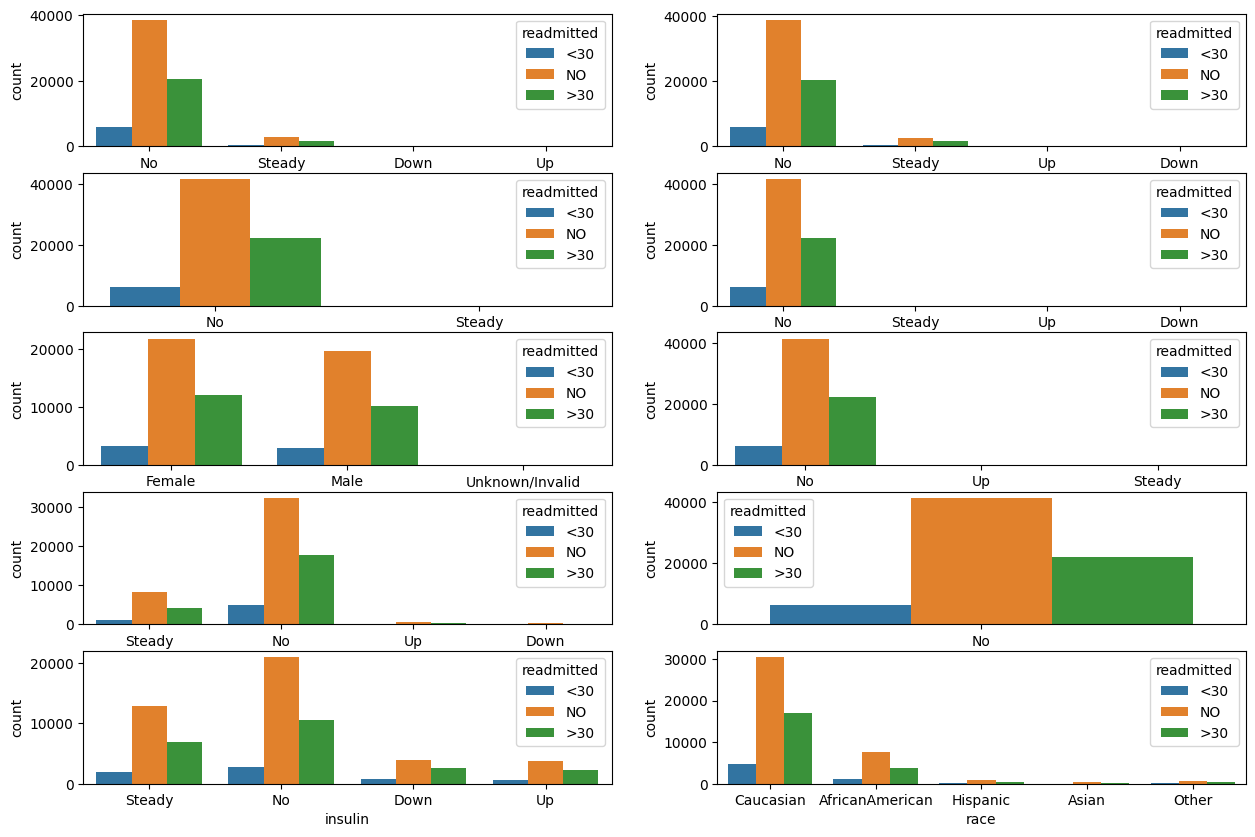

In [173]:
fig, axes = plt.subplots(5,2, figsize = (15, 10))

sns.countplot(x = 'pioglitazone', data = df, hue = 'readmitted', ax = axes[0, 0]);
sns.countplot(x = 'rosiglitazone', data = df, hue = 'readmitted', ax = axes[0, 1]);

sns.countplot(x = 'metformin-rosiglitazone', data = df, hue = 'readmitted', ax = axes[1, 0]);
sns.countplot(x = 'miglitol', data = df, hue = 'readmitted', ax = axes[1, 1]);

sns.countplot(x = 'gender', data = df, hue = 'readmitted', ax = axes[2, 0]);
sns.countplot(x = 'acarbose', data = df, hue = 'readmitted', ax = axes[2, 1]);

sns.countplot(x = 'metformin', data = df, hue = 'readmitted', ax = axes[3, 0]);
sns.countplot(x = 'citoglipton', data = df, hue = 'readmitted', ax = axes[3, 1]);

sns.countplot(x = 'insulin', data = df, hue = 'readmitted', ax = axes[4, 0]);
sns.countplot(x = 'race', data = df, hue = 'readmitted', ax = axes[4, 1]);

sns.countplot(x = 'change', data = df, hue = 'readmitted', ax = axes[5, 0]);
sns.countplot(x = 'max_glu_serum', data = df, hue = 'readmitted', ax = axes[5, 1]);

While we saw some differences in readmission by race, there was no measure of the confounding factors for implicit racial bias, therefore that variable was excluded as a factor from the model.

Other research has shown that African American's have lower medical intervention, but that has been an indication of racial bias within the medical community previously (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3797360/_).

In [ ]:
df = X.drop(['race'], axis= 1, inplace= True)

In [141]:
#filtering out expired and hospice patients
df = df[df["discharge_description"] != 'Expired']
df = df[df["discharge_description"] != 'Expired at home. Medicaid only, hospice.']
df = df[df["discharge_description"] != 'Hospice / home']
df = df[df["discharge_description"] != 'Hospice / medical facility']

In [142]:
df[['readmitted','change']].groupby('change').describe()

readmitted                  
            count unique top   freq
change                             
Ch          31489      3  NO  18047
No          38474      3  NO  23428

In [143]:
df[['readmitted','admission_description']].groupby('admission_description').describe()

readmitted                  
                           count unique top   freq
admission_description                             
Elective                   13846      3  NO   8915
Emergency                  35671      3  NO  20777
Newborn                        9      3  NO      6
Not Available               3121      3  NO   1783
Not Mapped                   291      3  NO    201
Trauma Center                 18      1  NO     18
Urgent                     12847      3  NO   7583

Admission code 1-Emergency, 2-Urgent, 3-Elective, 4-Newborn, 5-NotAvailable, 6-NULL, 7-Trauma Center, 8-NotMapped.
For Not Mapped and Null admission categories, the missing payer code is seen on almost all patients. Based on the levels of the payer code category, it would seem as if the missing value corresponds to patients who did not disclose a payment method (insurance or self-pay), which in itself, is a category level.

In [144]:
len(df)

69963

In [145]:
df.readmitted.value_counts()
# >30 does not count as within 30 days for our target, will replace

NO     41475
>30    22212
<30     6276
Name: readmitted, dtype: int64

In [146]:
y = df.readmitted.replace(to_replace='>30',value='NO')
y = label_binarize(y,classes=['NO','<30'])

In [160]:
# Make dataframe for model input
X = df.loc[:, df.columns != 'readmitted']

#remove repeated categorical columns for description, and discharge column, which has some values of the predictor
X = X[X.columns.drop(list(X.filter(regex='discharge')))]
X = X[X.columns.drop(list(X.filter(regex='_description')))]
X = X[X.columns.drop(list(X.filter(regex='id')))]


#one hot encoding categorical variables for model
cols = X.columns
num_cols = X._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

#creating dataframe of categorical columns
cat_df = X[cat_cols]
cat_df = pd.get_dummies(cat_df, columns=cat_df.columns)

#creating dataframe of numeric columns
num_df = X[num_cols]

X=cat_df.join(num_df)


X


,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,diag_3_110,diag_3_112,...,rosiglitazone_Steady,rosiglitazone_Up,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,0,0,1,0,0,1,0,0,0,0,...,0,0,8,77,6,33,0,0,0,8
378,0,0,1,0,0,1,0,0,0,0,...,0,0,2,49,1,11,0,0,0,3
729,1,0,0,0,0,1,0,0,0,0,...,0,0,4,68,2,23,0,0,0,9
774,0,1,0,0,0,1,0,0,0,0,...,0,0,3,46,0,20,0,0,0,9
927,0,0,1,0,0,1,0,0,0,0,...,0,0,5,49,0,5,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189351095,0,0,1,0,0,1,0,0,0,0,...,0,0,1,73,1,11,0,0,0,9
189365864,0,0,1,0,0,1,0,0,0,0,...,0,0,3,56,1,8,0,0,0,7
189445127,0,0,1,0,0,1,0,0,0,0,...,1,0,3,39,0,18,0,0,0,9


In [161]:
accuracy = []

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9071678696491102


Due to an excessively high prediction, we investigated which columns may be providing information on the predictive variable.

In [162]:
Weights = pd.Series(model.coef_[0], index = X.columns)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
idx = Weights['Weight'].abs().sort_values(ascending = False).head(20).index
Weights2 = Weights.loc[idx]
Weights2

,Var,Weight
1080,diag_1_434,0.875709
1332,diag_1_786,-0.476269
1363,diag_1_820,0.394685
1950,diag_2_707,0.350468
784,citoglipton_No,-0.348535
764,metformin-pioglitazone_No,-0.347085
2221,metformin-rosiglitazone_No,-0.344312
5,miglitol_No,-0.336822
1492,diag_1_V58,0.335327
1729,diag_2_403,0.324028


In [151]:
#creating dataframe to find where there is high readmitted rates for a variable
y_alt = df[['readmitted']]

y_alt = pd.get_dummies(y_alt, columns=y_alt.columns)

y_alt = y_alt[y_alt.columns.drop(list(y_alt.filter(regex='readmitted_''>30')))]
y_alt = y_alt[y_alt.columns.drop(list(y_alt.filter(regex='readmitted_NO')))]

df_alt=df.join(y_alt)
df_alt

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,insulin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_description,discharge_description,admission_source_description,readmitted_<30
patient_nbr,,,,,,,,,,,,,,,,,,,,,
135,Caucasian,Female,[50-60),8,77,6,33,0,0,0,...,Steady,No,No,Ch,Yes,<30,Urgent,Discharged to home,Physician Referral,1
378,Caucasian,Female,[50-60),2,49,1,11,0,0,0,...,No,No,No,No,No,NO,Elective,Discharged to home,Physician Referral,0
729,Caucasian,Female,[80-90),4,68,2,23,0,0,0,...,No,No,No,No,Yes,NO,Emergency,Discharged/transferred to SNF,Emergency Room,0
774,Caucasian,Female,[80-90),3,46,0,20,0,0,0,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,0
927,AfricanAmerican,Female,[30-40),5,49,0,5,0,0,0,...,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189351095,Caucasian,Female,[80-90),1,73,1,11,0,0,0,...,No,No,No,No,No,NO,Emergency,Discharged to home,Emergency Room,0
189365864,Other,Male,[60-70),3,56,1,8,0,0,0,...,Steady,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,0
189445127,Caucasian,Female,[80-90),3,39,0,18,0,0,0,...,Down,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,0


In [154]:
sum = df_alt[['number_inpatient','readmitted_<30']].groupby('number_inpatient').describe()
print(sum.to_string())

                 readmitted_<30                                               
                          count      mean       std  min   25%  50%   75%  max
number_inpatient                                                              
0                       61773.0  0.081168  0.273095  0.0  0.00  0.0  0.00  1.0
1                        5793.0  0.128949  0.335172  0.0  0.00  0.0  0.00  1.0
2                        1501.0  0.185210  0.388597  0.0  0.00  0.0  0.00  1.0
3                         463.0  0.237581  0.426061  0.0  0.00  0.0  0.00  1.0
4                         228.0  0.236842  0.426080  0.0  0.00  0.0  0.00  1.0
5                         102.0  0.284314  0.453315  0.0  0.00  0.0  1.00  1.0
6                          55.0  0.400000  0.494413  0.0  0.00  0.0  1.00  1.0
7                          19.0  0.473684  0.512989  0.0  0.00  0.0  1.00  1.0
8                          13.0  0.230769  0.438529  0.0  0.00  0.0  0.00  1.0
9                           7.0  0.428571  0.534522 

In [155]:
sum = df_alt[['number_emergency','readmitted_<30']].groupby('number_emergency').describe()
print(sum.to_string())

                 readmitted_<30                                             
                          count      mean       std  min  25%  50%  75%  max
number_emergency                                                            
0                       64863.0  0.087307  0.282287  0.0  0.0  0.0  0.0  1.0
1                        3882.0  0.112571  0.316108  0.0  0.0  0.0  0.0  1.0
2                         789.0  0.134347  0.341241  0.0  0.0  0.0  0.0  1.0
3                         242.0  0.128099  0.334893  0.0  0.0  0.0  0.0  1.0
4                          95.0  0.242105  0.430630  0.0  0.0  0.0  0.0  1.0
5                          32.0  0.156250  0.368902  0.0  0.0  0.0  0.0  1.0
6                          26.0  0.230769  0.429669  0.0  0.0  0.0  0.0  1.0
7                           8.0  0.125000  0.353553  0.0  0.0  0.0  0.0  1.0
8                           9.0  0.222222  0.440959  0.0  0.0  0.0  0.0  1.0
9                           4.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0

In [156]:
sum = df_alt[['number_outpatient','readmitted_<30']].groupby('number_outpatient').describe()
print(sum.to_string())

                  readmitted_<30                                             
                           count      mean       std  min  25%  50%  75%  max
number_outpatient                                                            
0                        60844.0  0.087897  0.283147  0.0  0.0  0.0  0.0  1.0
1                         4779.0  0.103578  0.304744  0.0  0.0  0.0  0.0  1.0
2                         1981.0  0.102978  0.304007  0.0  0.0  0.0  0.0  1.0
3                         1096.0  0.086679  0.281492  0.0  0.0  0.0  0.0  1.0
4                          574.0  0.114983  0.319279  0.0  0.0  0.0  0.0  1.0
5                          278.0  0.111511  0.315331  0.0  0.0  0.0  0.0  1.0
6                          122.0  0.090164  0.287598  0.0  0.0  0.0  0.0  1.0
7                           72.0  0.097222  0.298339  0.0  0.0  0.0  0.0  1.0
8                           56.0  0.053571  0.227208  0.0  0.0  0.0  0.0  1.0
9                           36.0  0.222222  0.421637  0.0  0.0  

<ipython-input-157-04e31bdaae7e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cormat = df_alt.corr()


Text(0.5, 1.0, 'Correlation Matrix')

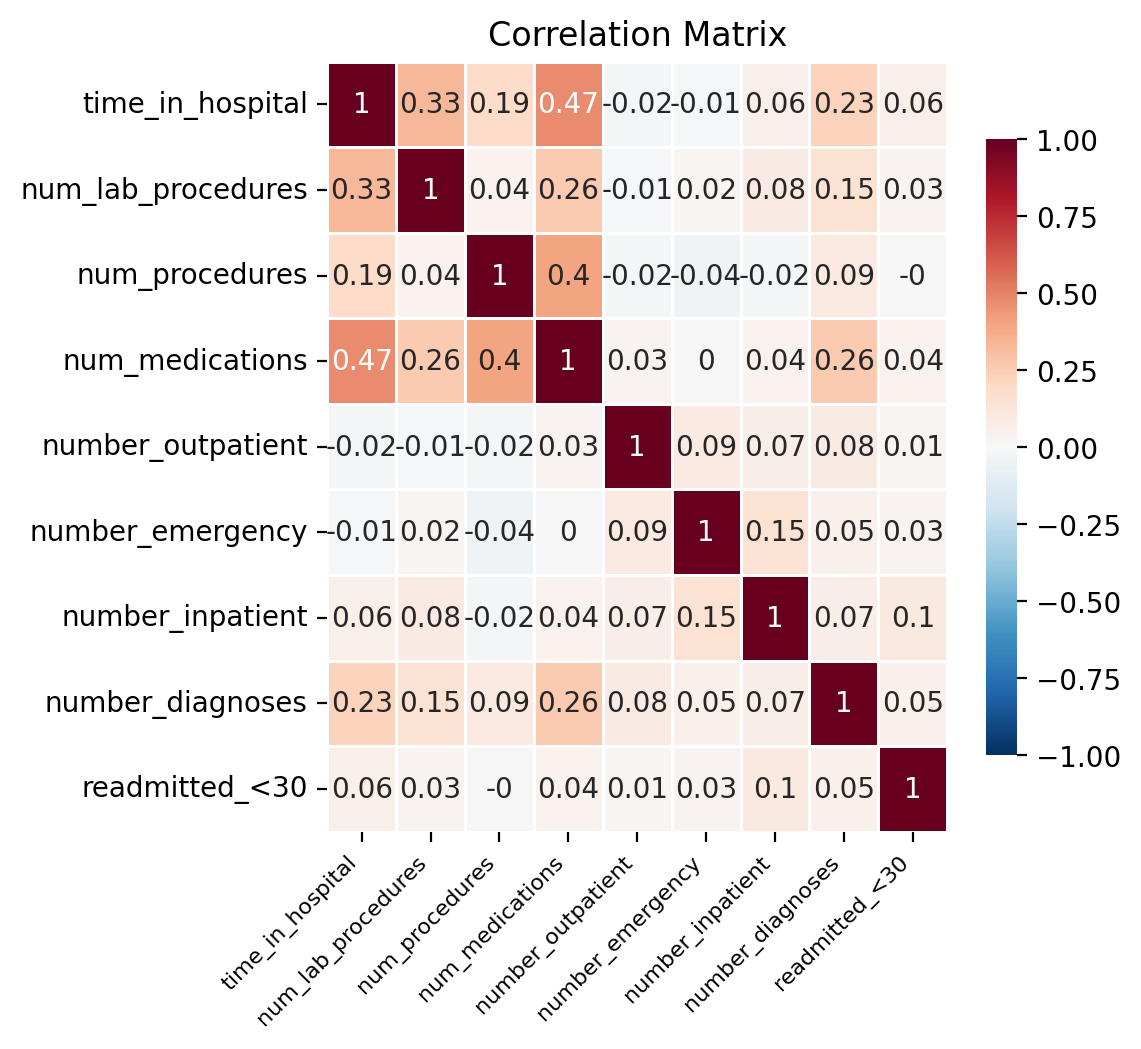

In [157]:
# Correlation df
cormat = df_alt.corr()
# Round to two decimals
cormat=round(cormat, 2)

plt.figure(figsize=(5, 5),dpi=200)
g=sns.heatmap(cormat,
            center=0, annot=True, linewidths=.5,
            cmap="RdBu_r", cbar_kws={"shrink": 0.8},vmin=-1,vmax=1);
g.set_xticklabels(g.get_xticklabels(),rotation=45,fontsize=8,ha='right')
plt.title('Correlation Matrix')


In [163]:
# Make dataframe for model input
X = df.loc[:, df.columns != 'readmitted']

#remove repeated categorical columns for description, and discharge column, which has some values of the predictor
X = X[X.columns.drop(list(X.filter(regex='discharge')))]
X = X[X.columns.drop(list(X.filter(regex='_description')))]
X = X[X.columns.drop(list(X.filter(regex='id')))]


#removing information from the dataframe, which are tied to information after a patient was admitted(isolating to information for initial admission)
X = X[X.columns.drop(list(X.filter(regex='time_in_hospital')))]
X = X[X.columns.drop(list(X.filter(regex='diag_2')))]
X = X[X.columns.drop(list(X.filter(regex='diag_3')))]

#removing data collected during hospital stay
X = X[X.columns.drop(list(X.filter(regex='_num')))]

#one hot encoding categorical variables for model
cols = X.columns
num_cols = X._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

#creating dataframe of categorical columns
cat_df = X[cat_cols]
cat_df = pd.get_dummies(cat_df, columns=cat_df.columns)

#creating dataframe of numeric columns
num_df = X[num_cols]
X=cat_df.join(num_df)



In [164]:
X_train, X_val, y_train, y_val = train_test_split(
     X, y, random_state=0)

model = LogisticRegression().fit(X_train, y_train)
model.score(X_val, y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9114401692298897

In [165]:
Weights = pd.Series(model.coef_[0], index = X.columns)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
idx = Weights['Weight'].abs().sort_values(ascending = False).head(20).index
Weights2 = Weights.loc[idx]
Weights2

,Var,Weight
288,diag_1_434,0.919910
540,diag_1_786,-0.560508
131,diag_1_250.7,0.479174
571,diag_1_820,0.365911
757,number_inpatient,0.359511
728,citoglipton_No,-0.355109
6,metformin-pioglitazone_No,-0.353444
732,metformin-rosiglitazone_No,-0.350149
718,miglitol_No,-0.342261
700,diag_1_V58,0.329950


In [166]:
X_alt=X.join(y_alt)
X_alt.groupby(['readmitted_<30']).mean().reset_index()
X_alt.describe()

X_alt.pivot_table('readmitted_<30', index='number_outpatient', columns='number_emergency')


number_emergency,0,1,2,3,4,5,6,7,8,9,10,11,13,16,20,25,37,42
number_outpatient,,,,,,,,,,,,,,,,,,
0,0.086031,0.112351,0.138889,0.105263,0.183333,0.095238,0.277778,0.000000,0.5,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,NaN
1,0.100596,0.108209,0.113475,0.155556,0.315789,0.400000,0.000000,0.333333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.096415,0.125926,0.114754,0.176471,0.428571,NaN,0.000000,NaN,NaN,0.0,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
3,0.076327,0.115385,0.205128,0.090909,0.250000,0.000000,0.500000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0.114990,0.104478,0.071429,0.333333,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.092593,0.190476,0.083333,0.333333,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.072165,0.076923,0.142857,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.100000,0.000000,0.000000,0.500000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.047619,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
model = LogisticRegression()


cv = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_idx, test_idx in cv.split(X, y_alt):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_alt.iloc[train_idx], y_alt.iloc[test_idx]

    model.fit(X_train, y_train)

    # Predict 
    y_pred = model.predict(X_test)

    # Calculate the accuracy, precision, recall and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average = 'weighted')
    recall = recall_score(y_test, y_pred, average = 'weighted')
    f1 = f1_score(y_test, y_pred, average = 'weighted')

    # add to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)
    print('\n')

# Print the mean 
print('\n')
print('Accuracy:', sum(accuracies) / len(accuracies))
print('Precision:', sum(precisions) / len(precisions))
print('Recall:', sum(recalls) / len(recalls))
print('F1-score:', sum(f1_scores) / len(f1_scores))
     

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9052451050450193
Precision: 0.8436841106199402
Recall: 0.9052451050450193
F1-score: 0.8607728945142253




/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
Weights = pd.Series(model.coef_[0], index = X.columns)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
idx = Weights['Weight'].abs().sort_values(ascending = False).head(20).index
Weights2 = Weights.loc[idx]
Weights2